# Laborator 10

Folosind un set de date - de exemplu de la https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=&numAtt=&numIns=&type=text&sort=taskDown&view=table - sa se rezolve o problema de clasificare sau regresie, plecand de la intrari de tip text.

Se poate opta pentru codificare BOW, n-grams, word2vec sau altele adecvate. Modelele de predictie pot fi din biblioteca scikit-learn. Puteti folosi pentru preprocesare biblioteca [NLTK](https://www.nltk.org) etc.

Pentru clasificare se va optimiza scorul F1; se vor raporta scorurile F1, accuracy. Pentru regresie se va optimia scorul mean squared error; se vor raporta scorurile MSE, mean absolute error, r2.

Exemple:
1. [Clasificare de SMS-uri](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)
1. [Sentence Classification Data Set](https://archive.ics.uci.edu/ml/datasets/Sentence+Classification#)
1. [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)
1. [Victorian Era Authorship Attribution Data Set](https://archive.ics.uci.edu/ml/datasets/Victorian+Era+Authorship+Attribution)
1. [Amazon Commerce reviews set Data Set](https://archive.ics.uci.edu/ml/datasets/Amazon+Commerce+reviews+set)
1. [Farm Ads Data Set](https://archive.ics.uci.edu/ml/datasets/Farm+Ads)
1. etc...


Se vor investiga minim 2 seturi de date si pentru fiecare din ele minim 4 modele de clasificare sau regresie. Daca setul de date e deja impartit in train si test, se va folosi ca atare - setul de antrenare se va imparti, suplimentar in train + validation; altfel, se va face kfold CV, k=5. Valorile optimale ale hiperparametrilor vor fi alesi prin random search si grid search.

Pentru fiecare set de date:
1. (2 x 0.5 p) Se descrie setul de date, in limba romana (continut, provenienta, problema etc.)
1. (2 x 1 p) Se face analiza exploratorie, folosind cod Python: distributia claselor sau a valorilor continue de iesire - numeric si grafic, statistici asupra textelor (de exemplu: lungime minima/medie/maxima; cele mai frecvente k cuvinte; clustering etc.). Se va explica fiecare pas si ce se urmareste prin efectuarea lui. Graficele vor avea axele numite (ce se reprezinta, evetual unitate de masura)
1. (2 x 0.5 p) Se face preprocesare de date; se explica in limba romana care sunt metodele de preprocesare folosite, efectul lor pe datele de intrare, ce forma are iesirea obtinuta; se arata efectele pasilor de preprocesare asupra setului de date (noul numar de documente, dinamica vocabularului, trasaturile rezultate etc.) Se pot aduga grafice si tabele la acest pas.
1. (2 x 4 x 0.5 p) Clasificare sau regresie, dupa caz: se face o descriere a modelelor considerate, in limba romana; se descrie modalitatea de cautare a hiperparametrilor; rezultatele obtinute se vor prezenta tabelar, similar cu tema precedenta. 

Se acorda doua puncte din oficiu.

Descrierea modelelor si a pasilor de preprocesare pot fi in sectiuni separate, cu referinte la acestea unde e necesar. Partea specifica aplicarii pasilor pe datele considerate va fi prezentata respectand ordinea de aplicare. 

Exemple:
1. [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
1. [Text Classification with Python and Scikit-Learn](https://stackabuse.com/text-classification-with-python-and-scikit-learn/)
1. [How to Prepare Text Data for Machine Learning with scikit-learn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

Prezentarea temei se va face in saptamana 20-24 mai.

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import MaxAbsScaler

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from textblob import TextBlob

print('Pandas version:', pd.__version__) #Pandas version: 0.23.4

Pandas version: 0.24.2


# Defining the regression models and auxiliary functions.

In [2]:
data = []
columns = ['Model', 'Search', 'train_accuracy', 'train_f1_macro', 'test_accuracy', 'test_f1_macro']
subset = ['train_accuracy', 'train_f1_macro', 'test_accuracy', 'test_f1_macro']

## Highlighting functions for pandas data frame

In [3]:
def highlight_max(s)-> pd.DataFrame:
    '''
    Colors the max cells in green, given a pandas DataFrame object.
    param:  s: the pandas DataFrame
    return: colored pandas DataFrame
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [4]:
def highlight_min(s)-> pd.DataFrame:
    '''
    Colors the min cells in red, given a pandas DataFrame object.
    param:  s: the pandas DataFrame;
    return: colored pandas DataFrame
    '''
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

## Errors function

In [5]:
def errors(model, x: np.ndarray, y: np.ndarray) -> list:
    '''
    Calculates the 'f1_macro' and 'accuracy' having the model as a param.
    param:   model: sklearn model, the given model that is needed for cross_validation;
             x: elements of data set;
             y: labels of data set;
    return:  list with the errors
    '''
    accuracy = cross_validate(model, x, y, cv=5, scoring='f1_macro', return_train_score=True)
    f1_macro = cross_validate(model, x, y, cv=5, scoring='accuracy', return_train_score=True)
    train_accuracy = accuracy['train_score']
    train_f1_macro = f1_macro['train_score']
    test_accuracy = accuracy['test_score']
    test_f1_macro = f1_macro['test_score']
    return [train_accuracy.mean(), train_f1_macro.mean(), 
           test_accuracy.mean(), test_f1_macro.mean()]

## Grid search and random search functions.

In [6]:
def search_random(parameters: dict, model, x: np.ndarray, y: np.ndarray) -> list:
    '''
    Dose the random cross validation search, it returns the best parameter found and than, the model goes to the error
    function to see how well it has done.
    param:   parameters: dictionary type, has the all the alternatives to the hyperparameters, the actual subject of
                         this function
             model: sklearn model, the given model that is needed for cross_validation;
             x: elements of data set;
             y: labels of data set;
    return:  list with erros returned by 'errors' function and the appropiate name.
    '''
    randomized_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, scoring='f1_macro', cv=3, return_train_score=True, iid=False)
    randomized_search.fit(x, y)
    return ['Random Search'] + errors(randomized_search, x, y)

In [7]:
def search_grid(parameters: dict, model, x: np.ndarray, y: np.ndarray) -> list:
    '''
    Dose the grid cross validation search, it returns the best parameter found and than, the model goes to the error
    function to see how well it has done.
    param:   parameters: dictionary type, has the all the alternatives to the hyperparameters, the actual subject of
                         this function
             model: sklearn model, the given model that is needed for cross_validation;
             x: elements of data set;
             y: labels of data set;
    return:  list with erros returned by 'errors' function and the appropiate name.
    '''
    grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring='f1_macro', cv=3, return_train_score=True, iid=False)
    grid_search.fit(x, y)
    return ['Grid Search'] + errors(grid_search, x, y)

## Model functions, KNN, SVR, Random Forest, Tree, GaussianProcessRegressor.

### KNeighborsRegressor

In [8]:
def search_knn(parameters: dict, x: np.ndarray, y: np.ndarray) -> None:
    '''
    Initialization for KNeighborsRegressor model and starting the grid and random search.
    Appends into a list the results
    ''' 
    model = KNeighborsClassifier()
    data.append(['KNN'] + search_grid(parameters, model, x, y))
    data.append(['KNN'] + search_random(parameters, model, x, y))

### SVR

In [9]:
def search_svc(parameters: dict, x: np.ndarray, y: np.ndarray) -> None:
    '''
    Initialization for SVR model and starting the grid and random search.
    Appends into a list the results
    '''
    model = SVC()
    data.append(['SVC'] + search_grid(parameters, model, x, y))
    data.append(['SVC'] + search_random(parameters, model, x, y))

### RandomForestRegressor

In [10]:
def search_forest(parameters: dict, x: np.ndarray, y: np.ndarray) -> None:
    '''
    Initialization for RandomForestRegressor model and starting the grid and random search.
    Appends into a list the results
    '''
    model = RandomForestClassifier()
    data.append(['Forest'] + search_grid(parameters, model, x, y))
    data.append(['Forest'] + search_random(parameters, model, x, y))

### DecisionTreeRegressor

In [11]:
def search_tree(parameters: dict, x: np.ndarray, y: np.ndarray) -> None:
    '''
    Initialization for DecisionTreeRegressor model and starting the grid and random search.
    App
    '''
    model = DecisionTreeClassifier()
    data.append(['Tree'] + search_grid(parameters, model, x, y))
    data.append(['Tree'] + search_random(parameters, model, x, y))

### GaussianProcessRegressor

In [12]:
def search_GaussianProcess(parameters: dict, x: np.ndarray, y: np.ndarray) -> None:
    '''
    Initialization for GaussianProcessRegressor model and starting the grid and random search.
    Appends into a list the results
    '''
    model = GaussianProcessClassifier()
    data.append(['GaussianProcess'] + (search_grid(parameters, model, x, y)))
    data.append(['GaussianProcess'] + (search_random(parameters, model, x, y)))

## The main function to deliver the search.

In [13]:
def search(x: np.ndarray, y: np.ndarray, name: str) -> None:
    '''
    Creates a pandas DataFrame object in witch it stores all the results that are needed. Exports the dataframe into a 
    HTML file.
    param:   x: the data set for the model;
             y: the labels set for the model;
             name: the name of export HTML file
    return:  None
    '''
    parameters_knn = {'n_neighbors': list(range(1,12)), 'p': [1, 2, 3, 4.7], 'metric': ['euclidean']}
    parameters_svr = {'C': list([0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]), 'gamma': ['auto']}
    parameters_forest = {'n_estimators': list(range(1,13))}
    parameters_tree = {'random_state': list([1, 50, 100, 200, 300, 333, 500, 700, 1000, 2000, 3000, 10000])}
    parameters_gaussian = {'max_iter_predict' : [100,150,200,250,300,350,400,450,500,550,600,650]}
    
    search_knn(parameters_knn, x, y)
    search_svc(parameters_svr, x, y)
    search_forest(parameters_forest, x, y)
    search_tree(parameters_tree, x, y)
    #search_GaussianProcess(parameters_gaussian, x, y)
    
    data_frame = pd.DataFrame(data, columns=columns)
    data_frame = data_frame.style.apply(highlight_max, subset=subset).apply(highlight_min, subset=subset)
    f=open(f"{name}.html","w")
    f.write(data_frame.render())
    f.close()
    data.clear()

# Data Preprocessing

## Spam Data Set

### Loading Data Set

In [75]:
data_spam = pd.read_csv("data/SMSSpamCollection", sep = '\t', names = ["category", "message"])
data_spam.head()

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [76]:
data_spam.groupby('category').describe()

message                                                            \
           count unique                                                top   
category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
category       
ham        30  
spam        4

In [77]:
''' Transformam label ul de predictie din "spam" si "ham" in "0" si "1" '''

data_spam = data_spam.replace(['ham','spam'], [0,1])
data_spam.head()

,category,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [78]:
data_spam_X = data_spam["message"]
data_spam_Y = data_spam["category"]

In [79]:
print('Cum este organizat textul: ', type(data_spam_X))
print('Cate date text sunt in dataframe: ', len(data_spam_X))
print('Primul text: ', data_spam_X[0])
print('Categoria asociata: ', data_spam_Y[0])
print('Numarul de clase din setul de date: ', np.unique(data_spam_Y))
print('Numarul de date din fiecare clasa: {0}'.format(np.bincount(data_spam_Y)))

Cum este organizat textul:  <class 'pandas.core.series.Series'>
Cate date text sunt in dataframe:  5572
Primul text:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Categoria asociata:  0
Numarul de clase din setul de date:  [0 1]
Numarul de date din fiecare clasa: [4825  747]


### Vocabulary

In [80]:
''' CountVectorizer din sklearn.feature_extraction.text serveste la selectarea cuvintelor din text 
si calculul frecventei de aparitie.
- stop_words -> specifica ca textul selectat sa fie cuvinte
- analyzer -> se face analiza de cuvinte
- ngram_range -> seturi de cuvinte consecutive
- min_df -> ignoră termenii care au o frecvență de aparitie (în % din documente) strict mai mică decât pragul dat
- max_df -> ignoră termenii care au o frecvență de aparitie (în % din documente) strict mai mare decât pragul dat
- max_feature -> limiteaza numărul de caracteristici pe care vectorizatorul le va învăța
'''

vect = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [81]:
'''Aici obtinem un vector bag of words prin aplicarea metodei transform:'''

data_spam_X = vect.fit_transform(data_spam_X)

In [82]:
''' Cuvintele distincte din text: '''

print(vect.vocabulary_)

{'jurong': 4248, 'point': 5779, 'crazy': 2282, 'available': 1284, 'bugis': 1719, 'great': 3555, 'world': 8285, 'la': 4374, 'buffet': 1717, 'cine': 2007, 'got': 3515, 'amore': 1064, 'wat': 8083, 'ok': 5377, 'lar': 4410, 'joking': 4216, 'wif': 8191, 'oni': 5403, 'free': 3280, 'entry': 2889, 'wkly': 8243, 'comp': 2123, 'win': 8203, 'fa': 3018, 'cup': 2341, 'final': 3135, 'tkts': 7569, '21st': 412, '2005': 403, 'text': 7437, '87121': 794, 'receive': 6158, 'question': 6052, 'std': 7077, 'txt': 7754, 'rate': 6104, 'apply': 1141, '08452810075over18': 77, 'dun': 2751, 'say': 6496, 'early': 2770, 'hor': 3840, 'nah': 5124, 'don': 2663, 'think': 7492, 'goes': 3479, 'usf': 7892, 'lives': 4562, 'freemsg': 3287, 'hey': 3757, 'darling': 2398, 'week': 8129, 'word': 8276, 'like': 4512, 'fun': 3342, 'tb': 7372, 'xxx': 8350, 'chgs': 1961, 'send': 6584, '50': 616, 'rcv': 6116, 'brother': 1689, 'speak': 6959, 'treat': 7687, 'aids': 997, 'patent': 5582, 'request': 6267, 'melle': 4862, 'oru': 5461, 'minnamin

In [83]:
''' Reprezentarea ca vectori rari: '''

print(data_spam_X)

  (0, 4248)	1
  (0, 5779)	1
  (0, 2282)	1
  (0, 1284)	1
  (0, 1719)	1
  (0, 3555)	1
  (0, 8285)	1
  (0, 4374)	1
  (0, 1717)	1
  (0, 2007)	1
  (0, 3515)	1
  (0, 1064)	1
  (0, 8083)	1
  (1, 5377)	1
  (1, 4410)	1
  (1, 4216)	1
  (1, 8191)	1
  (1, 5403)	1
  (2, 3280)	1
  (2, 2889)	2
  (2, 8243)	1
  (2, 2123)	1
  (2, 8203)	1
  (2, 3018)	2
  (2, 2341)	1
  :	:
  (5567, 2781)	1
  (5567, 309)	1
  (5567, 710)	1
  (5567, 5840)	1
  (5567, 165)	1
  (5567, 5297)	1
  (5568, 3813)	1
  (5568, 3484)	1
  (5568, 3267)	1
  (5568, 2921)	1
  (5569, 5022)	1
  (5569, 5711)	1
  (5569, 7217)	1
  (5570, 3280)	1
  (5570, 8129)	1
  (5570, 4512)	1
  (5570, 2546)	1
  (5570, 3392)	1
  (5570, 1753)	1
  (5570, 3609)	1
  (5570, 4067)	1
  (5570, 911)	1
  (5570, 1515)	1
  (5571, 7709)	1
  (5571, 6366)	1


In [84]:
''' Reprezentarea ca vectori: '''

print(data_spam_X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [85]:
''' Se realizeaza scalarea datelor '''

scaler = MaxAbsScaler()

data_spam_X = scaler.fit_transform(data_spam_X)
print(data_spam_X)

  (0, 1064)	1.0
  (0, 1284)	1.0
  (0, 1717)	1.0
  (0, 1719)	1.0
  (0, 2007)	1.0
  (0, 2282)	0.5
  (0, 3515)	0.5
  (0, 3555)	0.3333333333333333
  (0, 4248)	1.0
  (0, 4374)	1.0
  (0, 5779)	1.0
  (0, 8083)	0.5
  (0, 8285)	0.5
  (1, 4216)	1.0
  (1, 4410)	0.5
  (1, 5377)	0.3333333333333333
  (1, 5403)	1.0
  (1, 8191)	0.5
  (2, 77)	1.0
  (2, 403)	1.0
  (2, 412)	1.0
  (2, 794)	1.0
  (2, 1141)	1.0
  (2, 2123)	1.0
  (2, 2341)	1.0
  :	:
  (5567, 5840)	1.0
  (5567, 5934)	0.5
  (5567, 6104)	1.0
  (5567, 7546)	0.3333333333333333
  (5567, 7696)	1.0
  (5567, 8260)	1.0
  (5568, 2921)	1.0
  (5568, 3267)	1.0
  (5568, 3484)	0.5
  (5568, 3813)	0.5
  (5569, 5022)	1.0
  (5569, 5711)	1.0
  (5569, 7217)	1.0
  (5570, 911)	1.0
  (5570, 1515)	1.0
  (5570, 1753)	0.5
  (5570, 2546)	0.3333333333333333
  (5570, 3280)	0.3333333333333333
  (5570, 3392)	1.0
  (5570, 3609)	0.5
  (5570, 4067)	1.0
  (5570, 4512)	0.3333333333333333
  (5570, 8129)	0.3333333333333333
  (5571, 6366)	1.0
  (5571, 7709)	0.5


In [86]:
''' Dimensiunea vocabularului: '''

feature_names = vect.get_feature_names()
print(len(feature_names))

8444


In [87]:
'''Vocabularul in sine'''

print(feature_names)

['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400', '02073162414', '02085076972', '021', '03', '04', '0430', '05', '050703', '0578', '06', '07', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07781482378', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '078498', '07880867867', '0789xxxxxxx', '07946746291', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '08', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '083', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18', '0870', '08700435505150p', '

### Stats About Data Set

In [88]:
spam_dataFrame = data_spam
spam_dataFrame.head()

,category,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [89]:
spam_dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
category    5572 non-null int64
message     5572 non-null object
dtypes: int64(1), object(1)
memory usage: 87.1+ KB


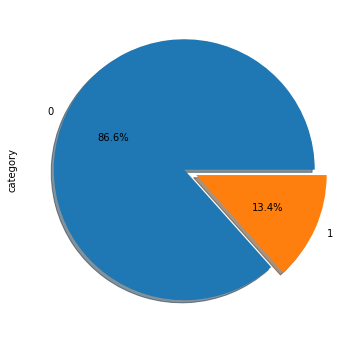

In [90]:
spam_dataFrame["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.show()

In [91]:
spam_dataFrame['review_len'] =  spam_dataFrame['message'].astype(str).apply(len)
spam_dataFrame['word_count'] =  spam_dataFrame['message'].apply(lambda x: len(str(x).split()))

[]

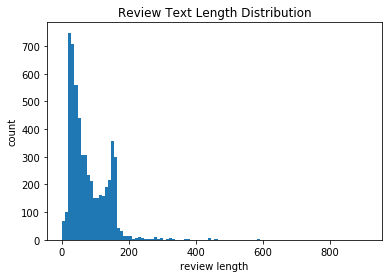

In [92]:
spam_dataFrame['review_len'].plot(
    kind='hist',
    bins=100,
    title='Review Text Length Distribution')
plt.ylabel("count")
plt.xlabel("review length")
plt.plot()

[]

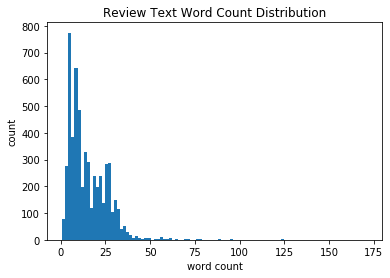

In [93]:
spam_dataFrame['word_count'].plot(
    kind='hist',
    bins=100,
    title='Review Text Word Count Distribution')
plt.ylabel("count")
plt.xlabel("word count")
plt.plot()

In [22]:
spam_messages = spam_dataFrame[spam_dataFrame["category"] == "spam"]["message"]
ham_messages = spam_dataFrame[spam_dataFrame["category"] == "ham"]["message"]
spam_words = []
ham_words = []

In [23]:
def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words

In [24]:
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

In [25]:
spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
7       None
10      None
13      None
14      None
16      None
17      None
18      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
35      None
36      None
37      None
38      None
        ... 
5540    None
5541    None
5543    None
5544    None
5545    None
5546    None
5547    None
5548    None
5550    None
5551    None
5552    None
5553    None
5554    None
5555    None
5556    None
5557    None
5558    None
5559    None
5560    None
5561    None
5562    None
5563    None
5564    None
5565    None
5566    None
5567    None
5570    None
5571    None
5572    None
5573    None
Name: message, Length: 4827, dtype: object

In [26]:
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      217
txt       156
ur        144
u         144
mobile    123
text      121
stop      118
claim     113
reply     104
dtype: int64

In [27]:
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       991
gt      318
lt      316
get     302
go      249
ur      247
ok      247
got     245
know    235
like    233
dtype: int64

## Sentiment Data Set

## Loading Data Set

In [47]:
dataframe_imdb = pd.read_csv("data/imdb_labelled", names = ["message", "category"], sep = '\t')
dataframe_yelp = pd.read_csv("data/yelp_labelled", names = ["message", "category"], sep = '\t')
dataframe_amazon = pd.read_csv("data/amazon_cells_labelled", names = ["message", "category"], sep = '\t')

dataframe = dataframe_imdb
dataframe.append(dataframe_yelp, ignore_index=True)
dataframe.append(dataframe_amazon, ignore_index=True)

dataframe.head()

,message,category
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [48]:
dataframe.groupby('category').describe()

message                                              
           count unique                               top freq
category                                                      
0            362    361                Not recommended.      2
1            386    384  Definitely worth checking out.      2

In [49]:
dataframe_X = dataframe["message"]
dataframe_Y = dataframe["category"]

In [50]:
print('Cum este organizat textul: ', type(dataframe_X))
print('Cate date text sunt in dataframe: ', len(dataframe_X))
print('Primul text: ', dataframe_X[0])
print('Categoria asociata: ', dataframe_Y[0])
print('Numarul de clase din setul de date: ', np.unique(dataframe_Y))
print('Numarul de date din fiecare clasa: {0}'.format(np.bincount(dataframe_Y)))

Cum este organizat textul:  <class 'pandas.core.series.Series'>
Cate date text sunt in dataframe:  748
Primul text:  A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  
Categoria asociata:  0
Numarul de clase din setul de date:  [0 1]
Numarul de date din fiecare clasa: [362 386]


### Vocabulary

In [53]:
''' CountVectorizer din sklearn.feature_extraction.text serveste la selectarea cuvintelor din text 
si calculul frecventei de aparitie.
- stop_words -> specifica ca textul selectat sa fie cuvinte
- analyzer -> se face analiza de cuvinte
- ngram_range -> seturi de cuvinte consecutive
- min_df -> ignoră termenii care au o frecvență de aparitie (în % din documente) strict mai mică decât pragul dat
- max_df -> ignoră termenii care au o frecvență de aparitie (în % din documente) strict mai mare decât pragul dat
- max_feature -> limiteaza numărul de caracteristici pe care vectorizatorul le va învăța
'''

vect = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [54]:
'''Aici obtinem un vector bag of words prin aplicarea metodei transform:'''

dataframe_X = vect.fit_transform(dataframe_X)
dataframe_X

<748x2811 sparse matrix of type '<class 'numpy.int64'>'
	with 6251 stored elements in Compressed Sparse Row format>

In [56]:
''' Cuvintele distincte din text: '''

print(vect.vocabulary_)

{'slow': 2233, 'moving': 1627, 'aimless': 87, 'movie': 1625, 'distressed': 697, 'drifting': 732, 'young': 2803, 'man': 1524, 'sure': 2389, 'lost': 1491, 'flat': 958, 'characters': 385, 'audience': 170, 'nearly': 1650, 'half': 1117, 'walked': 2695, 'attempting': 166, 'artiness': 145, 'black': 250, 'white': 2741, 'clever': 432, 'camera': 333, 'angles': 114, 'disappointed': 679, 'ridiculous': 2041, 'acting': 54, 'poor': 1847, 'plot': 1831, 'lines': 1461, 'non': 1672, 'existent': 851, 'little': 1467, 'music': 1636, 'speak': 2274, 'best': 238, 'scene': 2108, 'gerardo': 1049, 'trying': 2555, 'song': 2255, 'keeps': 1367, 'running': 2076, 'head': 1145, 'rest': 2023, 'lacks': 1398, 'art': 143, 'charm': 390, 'meaning': 1555, 'emptiness': 788, 'works': 2775, 'guess': 1106, 'wasted': 2711, 'hours': 1210, 'saw': 2099, 'today': 2495, 'thought': 2469, 'good': 1075, 'effort': 765, 'messages': 1576, 'kids': 1374, 'bit': 248, 'predictable': 1868, 'loved': 1497, 'casting': 360, 'jimmy': 1340, 'buffet': 3

In [57]:
''' Reprezentarea ca vectori rari: '''

print(dataframe_X)

  (0, 2233)	1
  (0, 1627)	1
  (0, 87)	1
  (0, 1625)	1
  (0, 697)	1
  (0, 732)	1
  (0, 2803)	1
  (0, 1524)	1
  (1, 2389)	1
  (1, 1491)	1
  (1, 958)	1
  (1, 385)	1
  (1, 170)	1
  (1, 1650)	1
  (1, 1117)	1
  (1, 2695)	1
  (2, 1625)	1
  (2, 166)	1
  (2, 145)	1
  (2, 250)	1
  (2, 2741)	1
  (2, 432)	1
  (2, 333)	1
  (2, 114)	1
  (2, 679)	1
  :	:
  (742, 910)	1
  (743, 1362)	1
  (743, 2717)	1
  (743, 1080)	1
  (743, 282)	1
  (743, 1405)	1
  (743, 1337)	1
  (743, 440)	1
  (744, 1491)	1
  (744, 935)	1
  (744, 1894)	1
  (744, 2772)	1
  (744, 2129)	1
  (744, 2606)	1
  (744, 2676)	1
  (744, 1985)	1
  (745, 2770)	1
  (745, 777)	1
  (746, 195)	1
  (746, 841)	1
  (747, 2710)	1
  (747, 1606)	1
  (747, 1216)	1
  (747, 1294)	1
  (747, 1290)	1


In [58]:
''' Reprezentarea ca vectori: '''

print(dataframe_X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [59]:
''' Se realizeaza scalarea datelor '''

scaler = MaxAbsScaler()

dataframe_X = scaler.fit_transform(dataframe_X)
print(dataframe_X)

  (0, 87)	1.0
  (0, 697)	1.0
  (0, 732)	1.0
  (0, 1524)	0.5
  (0, 1625)	0.0625
  (0, 1627)	1.0
  (0, 2233)	1.0
  (0, 2803)	1.0
  (1, 170)	1.0
  (1, 385)	0.3333333333333333
  (1, 958)	1.0
  (1, 1117)	1.0
  (1, 1491)	1.0
  (1, 1650)	1.0
  (1, 2389)	1.0
  (1, 2695)	1.0
  (2, 54)	0.25
  (2, 114)	1.0
  (2, 145)	1.0
  (2, 166)	1.0
  (2, 250)	0.5
  (2, 333)	1.0
  (2, 432)	1.0
  (2, 679)	1.0
  (2, 851)	1.0
  :	:
  (742, 2695)	1.0
  (743, 282)	1.0
  (743, 440)	1.0
  (743, 1080)	1.0
  (743, 1337)	1.0
  (743, 1362)	0.16666666666666666
  (743, 1405)	1.0
  (743, 2717)	0.3333333333333333
  (744, 935)	0.07142857142857142
  (744, 1491)	1.0
  (744, 1894)	1.0
  (744, 1985)	1.0
  (744, 2129)	0.25
  (744, 2606)	1.0
  (744, 2676)	1.0
  (744, 2772)	0.5
  (745, 777)	1.0
  (745, 2770)	1.0
  (746, 195)	0.125
  (746, 841)	1.0
  (747, 1216)	1.0
  (747, 1290)	1.0
  (747, 1294)	1.0
  (747, 1606)	0.5
  (747, 2710)	0.5


In [60]:
''' Dimensiunea vocabularului: '''

feature_names = vect.get_feature_names()
print(len(feature_names))

2811


In [61]:
'''Vocabularul in sine'''

print(feature_names)

['10', '12', '13', '15', '15pm', '17', '18th', '1928', '1947', '1948', '1949', '1971', '1973', '1980', '1986', '1995', '1998', '20', '2005', '2006', '20th', '25', '30', '40', '50', '54', '70', '70000', '70s', '80', '80s', '8pm', '90', '95', 'aailiyah', 'abandoned', 'ability', 'abroad', 'absolutely', 'abstruse', 'abysmal', 'academy', 'accents', 'accessible', 'acclaimed', 'accolades', 'accurate', 'accurately', 'accused', 'achievement', 'achille', 'ackerman', 'act', 'acted', 'acting', 'action', 'actions', 'actor', 'actors', 'actress', 'actresses', 'actually', 'adams', 'adaptation', 'add', 'added', 'addition', 'admins', 'admiration', 'admitted', 'adorable', 'adrift', 'adventure', 'advise', 'aerial', 'aesthetically', 'affected', 'affleck', 'afraid', 'africa', 'afternoon', 'age', 'aged', 'ages', 'ago', 'agree', 'agreed', 'aimless', 'air', 'aired', 'akasha', 'akin', 'alert', 'alexander', 'alike', 'allison', 'allow', 'allowing', 'alongside', 'amateurish', 'amaze', 'amazed', 'amazing', 'amazing

### Stats About

In [62]:
sentiment_dataFrame = dataframe

In [63]:
sentiment_dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
message     748 non-null object
category    748 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


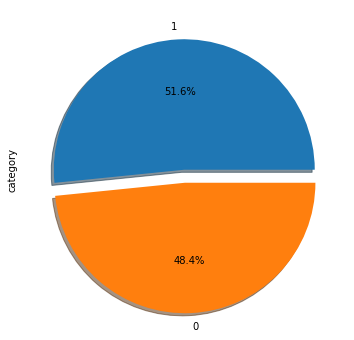

In [64]:
sentiment_dataFrame["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.show()

In [68]:
''' Folosind TextBlob calculam polaritatea sentimentului care se situează în intervalul [-1,1] unde 1 înseamnă sentiment pozitiv și -1 înseamnă un sentiment negativ. '''

sentiment_dataFrame['polarity'] = sentiment_dataFrame['message'].map(lambda text: TextBlob(text).sentiment.polarity)
sentiment_dataFrame['review_len'] =  sentiment_dataFrame['message'].astype(str).apply(len)
sentiment_dataFrame['word_count'] =  sentiment_dataFrame['message'].apply(lambda x: len(str(x).split()))

In [69]:
print('5 review-uri random cu notate cu sentiment pozitiv: ')
data = sentiment_dataFrame.loc[sentiment_dataFrame.polarity == 1, ['message']].sample(5).values
for value in data:
    print(value[0])

5 review-uri random cu notate cu sentiment pozitiv: 
An excellent performance from Ms.  
The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  
This movie is so awesome!  
I was deeply impressed with the character he played.  
Excellently produced by one of Sci-fi's best producers Scot Vandiver !  


In [70]:
print('5 review-uri random cu notate cu sentiment negativ: ')
data = sentiment_dataFrame.loc[sentiment_dataFrame.polarity == -1, ['message']].sample(5).values
for value in data:
    print(value[0])

5 review-uri random cu notate cu sentiment negativ: 
Every time he opened his mouth you expect to hear, "you see kids..." Pulling the plug was a mercy killing for this horrible show.  
Oh yeah, and the storyline was pathetic too.  
The "explosion" of the Gas tanks at the end was just as awful.  
The story line is just awful!  
It was so BORING!  


In [71]:
print('5 review-uri random cu notate cu sentiment neutru: ')
data = sentiment_dataFrame.loc[sentiment_dataFrame.polarity == 0, ['message']].sample(5).values
for value in data:
    print(value[0])

5 review-uri random cu notate cu sentiment neutru: 
This is not movie-making.  
See it.  
However, after seeing the short again after about 25 years, I was amazed at how timeless the film actually is.  
You will leave the theater wanting to go out and dance under the stars.  
Too politically correct.  


[]

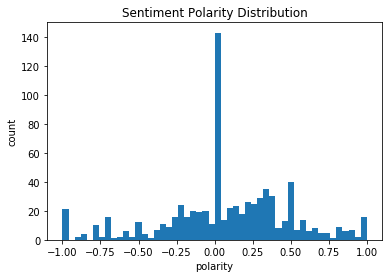

In [72]:
sentiment_dataFrame['polarity'].plot(
    kind='hist',
    bins=50,
    title='Sentiment Polarity Distribution')
plt.ylabel("count")
plt.xlabel("polarity")
plt.plot()

[]

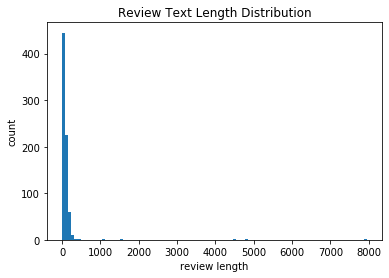

In [73]:
sentiment_dataFrame['review_len'].plot(
    kind='hist',
    bins=100,
    title='Review Text Length Distribution')
plt.ylabel("count")
plt.xlabel("review length")
plt.plot()

[]

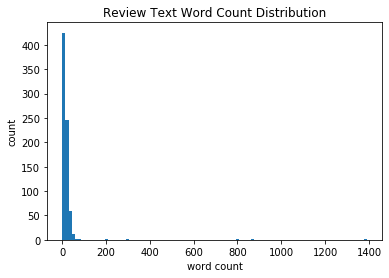

In [74]:
sentiment_dataFrame['word_count'].plot(
    kind='hist',
    bins=100,
    title='Review Text Word Count Distribution')
plt.ylabel("count")
plt.xlabel("word count")
plt.plot()

In [36]:
bad_review_messages = sentiment_dataFrame[sentiment_dataFrame["category"] == 0]["message"]
good_review_messages = sentiment_dataFrame[sentiment_dataFrame["category"] == 1]["message"]

bad_review_words = []
good_review_words = []

In [37]:
def extract_bad_review_words(badReview):
    global bad_review_words
    words = [word.lower() for word in word_tokenize(badReview) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    bad_review_words = bad_review_words + words

In [38]:
def extract_good_review_words(goodReview):
    global good_review_words
    words = [word.lower() for word in word_tokenize(goodReview) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    good_review_words = good_review_words + words

In [39]:
bad_review_messages.apply(extract_bad_review_words)
good_review_messages.apply(extract_good_review_words)

1       None
2       None
4       None
7       None
10      None
11      None
13      None
15      None
17      None
18      None
21      None
23      None
25      None
26      None
31      None
34      None
36      None
38      None
40      None
42      None
44      None
45      None
48      None
51      None
52      None
53      None
54      None
55      None
57      None
58      None
        ... 
2850    None
2852    None
2853    None
2856    None
2857    None
2860    None
2861    None
2863    None
2864    None
2865    None
2866    None
2867    None
2868    None
2872    None
2873    None
2877    None
2878    None
2882    None
2888    None
2890    None
2891    None
2894    None
2895    None
2896    None
2897    None
2899    None
2901    None
2907    None
2909    None
2922    None
Name: message, Length: 1500, dtype: object

In [40]:
print("Top 10 bad review words are :\n")
pd.Series(bad_review_words).value_counts().head(n = 10)

Top 10 bad review words are :



bad      97
movie    94
phone    78
one      69
like     67
would    66
food     65
time     61
film     57
place    56
dtype: int64

In [41]:
print("Top 10 good review words are :\n")
pd.Series(good_review_words).value_counts().head(n = 10)

Top 10 good review words are :



great    200
good     173
film     102
phone     87
movie     86
one       76
best      63
well      62
food      60
place     58
dtype: int64

# Learning the machine

## Spam

In [51]:
search(data_spam_X, data_spam_Y, "spam")

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-def

## Sentiment

In [52]:
search(data_sentiment_X, data_sentiment_Y, "sentiment")

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-def

# Documentation Of Data Sets

## Spam

In [ ]:
'''
Scopul acestui set de date este de a afla daca un text este sau nu spam.
Informatiile data-setului au fost preluate de la surse de cercetare gratuite, printre care se enumera urmatoarele:
[1] GÃ³mez Hidalgo, J.M., Cajigas Bringas, G., Puertas Sanz, E., Carrero GarcÃ­a, F. Content Based SMS Spam Filtering.
    Proceedings of the 2006 ACM Symposium on Document Engineering (ACM DOCENG'06),
    Amsterdam, The Netherlands, 10-13,2006. 
[2] Cormack, G. V., GÃ³mez Hidalgo, J. M., and Puertas SÃ¡nz, E. Feature engineering for mobile (SMS) spam filtering.
    Proceedings of the 30th Annual international ACM Conference on Research and Development in information Retrieval
    (ACM SIGIR'07), New York, NY, 871-872, 2007. 
[3] Cormack, G. V., GÃ³mez Hidalgo, J. M., and Puertas SÃ¡nz, E. Spam filtering for short messages. 
    Proceedings of the 16th ACM Conference on Information and Knowledge Management (ACM CIKM'07).
    Lisbon, Portugal, 313-320, 2007.
Setul contine clasa la inceput (0 daca este spam , altfel 1), dupa care e acompaniat de un text care reprezinta emailul.
'''

## Sentiment

In [ ]:
'''
Informatiile de la acest set de date sunt preluate de la 'From Group to Individual Labels using Deep Features', 
Kotzias et. al,. KDD 2015.
Setul de date contine o recenzie facuta la un film , produs etc si un scor pozitiv sau negativ, 
care arata sentimentul pozitiv sau negativ al textului, atasat fiecaruia.
Problema setului de date este de a afla daca un text are o recenzie buna sau proasta. ("sentimentul utilizatorului")
'''